<a href="https://colab.research.google.com/github/JcandZero/Test-task/blob/main/%E7%94%A8PyTorch%E5%AE%9E%E7%8E%B0Mnist%E6%89%8B%E5%86%99%E6%95%B0%E5%AD%97%E8%AF%86%E5%88%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#使用了基于Google colab中的谷歌计算资源，来进行计算

使用了Pytorch架构进行mnist手写数字识别

In [20]:
#导入pytorch框架，导入其他包

In [21]:
import torch
import torchvision
from torch.utils.data import DataLoader

定义超参数（paremeter）

In [22]:
n_epochs = 14#设置不同的epoch以测试
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed) #为了再现结果，设置random_seed

1.设置dataloader，包括train和test的data

2.进行了特征预处理，Normalize，将数据集的全局平均值设置0.1307，标准偏差为0.3081


In [23]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

查看数据

In [24]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)

tensor([3, 9, 4, 9, 9, 0, 8, 3, 1, 2, 3, 9, 1, 3, 6, 6, 4, 4, 9, 7, 3, 7, 6, 3,
        4, 8, 4, 6, 8, 6, 1, 1, 1, 1, 0, 0, 1, 8, 4, 0, 1, 2, 7, 9, 3, 2, 3, 8,
        3, 2, 0, 4, 6, 6, 5, 5, 3, 0, 3, 7, 2, 4, 1, 6, 7, 5, 4, 1, 0, 8, 5, 9,
        0, 9, 6, 1, 8, 0, 9, 3, 5, 7, 8, 5, 6, 4, 2, 2, 2, 1, 8, 4, 4, 2, 1, 5,
        9, 3, 7, 0, 4, 1, 7, 2, 2, 6, 5, 1, 2, 6, 1, 3, 1, 2, 7, 4, 1, 3, 2, 9,
        3, 7, 2, 7, 4, 7, 0, 0, 9, 0, 9, 5, 1, 6, 9, 8, 1, 4, 6, 7, 5, 5, 6, 4,
        5, 4, 0, 7, 4, 1, 3, 8, 2, 6, 2, 2, 8, 4, 1, 9, 6, 7, 5, 0, 7, 4, 6, 2,
        6, 8, 7, 9, 8, 0, 7, 4, 2, 4, 9, 0, 4, 6, 5, 6, 6, 4, 4, 8, 3, 8, 0, 9,
        5, 6, 3, 3, 8, 4, 4, 6, 7, 8, 5, 3, 4, 3, 3, 3, 3, 1, 8, 8, 9, 1, 0, 1,
        4, 1, 0, 2, 0, 6, 5, 1, 5, 8, 8, 1, 3, 9, 4, 5, 9, 2, 5, 6, 5, 8, 2, 7,
        4, 1, 6, 8, 7, 9, 3, 3, 4, 4, 5, 4, 9, 8, 2, 9, 1, 6, 7, 1, 0, 5, 1, 9,
        2, 1, 5, 2, 7, 9, 0, 0, 6, 0, 8, 7, 2, 6, 1, 7, 6, 1, 2, 1, 6, 3, 1, 4,
        1, 7, 5, 9, 3, 8, 6, 3, 8, 7, 4,

利用matplotlib来绘制一些字符

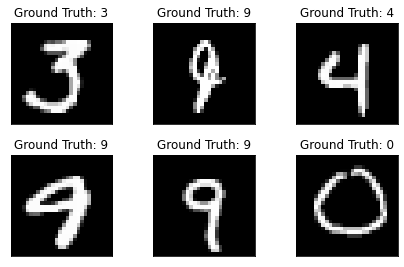

In [25]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

#神经网络布置-使用CNN网络（提供两种sequential函数的方法）

其中神经元的单元选用Conv2d的2d卷积层，和两个线性函数

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

**更换神经网络层**（此层代码与上面的代码选择使用）

此层函数使用的较为复杂，混合使用Conv2d、BatchNorm2d、Relu等函数

已全部注释化

In [27]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# def __init__(self):
#         super(Net, self).__init__()
          
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

# def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
        
#         return F.log_softmax(x) 

 广义地说，我们可以想到torch.nn层中包含可训练的参数，而torch.nn.functional就是纯粹的功能性。forward()传递定义了使用给定的层和函数计算输出的方式。为了便于调试，在前向传递中打印出张量是完全可以的。在试验更复杂的模型时，这就派上用场了。请注意，前向传递可以使用成员变量甚至数据本身来确定执行路径——它还可以使用多个参数!
 

现在让我们初始化网络和优化器。


In [28]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

#模型训练

In [29]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

先使用随机初始化的网络参数来计算损失，看看准确度

In [30]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')
          
train(1) #训练一个epoch

<ipython-input-26-f14b5dfe1d84>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.290954
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.318535
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.261000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259137
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.229576
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.196151
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.181698
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.088444
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.014765
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.818533
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.822772
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.838733
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.530556
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.738141
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.420971
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.369238
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.335397
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.182360
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.056649
Train Epoch: 1 [12800/60000 (

In [31]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))



test()

<ipython-input-26-f14b5dfe1d84>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1911, Accuracy: 9439/10000 (94%)



我们可以避免将生成网络输出的计算结果存储在计算图中。是时候开始训练了!我们将在循环遍历n_epochs之前手动添加test()调用，以使用随机初始化的参数来评估我们的模型。

In [32]:
test()# 不加这个，后面画图就会报错：x and y must be the same size
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

<ipython-input-26-f14b5dfe1d84>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.1911, Accuracy: 9439/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.359436
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.382616
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.622312
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.488098
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.297355
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.182658
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.457787
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.492744
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.467196
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.702105
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.481813
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.351125
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.397469
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.561537
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.464565
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.446449
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.304118
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.577272
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.347102
Train Epoch: 1 [12160

#评估模型的性能

就是这样。仅仅经过3个阶段的训练，我们已经能够达到测试集97%的准确率!我们开始使用随机初始化的参数，正如预期的那样，在开始训练之前，测试集的准确率只有10%左右。

我们来画一下训练曲线。

ValueError: ignored

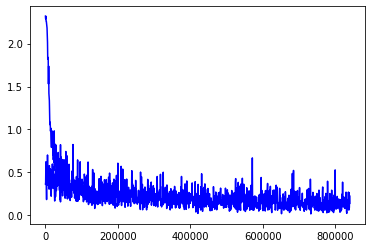

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

从训练曲线来看，看起来我们甚至可以继续训练几个epoch!

但在此之前，让我们再看看几个例子，正如我们之前所做的，并比较模型的输出。

<ipython-input-26-f14b5dfe1d84>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


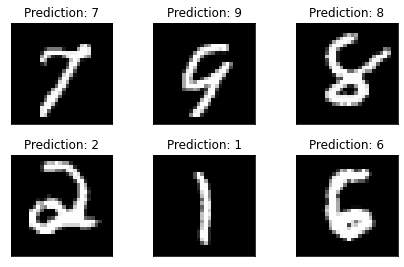

In [34]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
  output = network(example_data)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()

#检查点的持续训练

现在让我们继续对网络进行训练，或者看看如何从第一次培训运行时保存的state_dicts中继续进行训练。我们将初始化一组新的网络和优化器。

In [35]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

使用.load_state_dict()，我们现在可以加载网络的内部状态，并在最后一次保存它们时优化它们。

In [36]:
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

同样，运行一个训练循环应该立即恢复我们之前的训练。为了检查这一点，我们只需使用与前面相同的列表来跟踪损失值。由于我们为所看到的训练示例的数量构建测试计数器的方式，我们必须在这里手动添加它。

In [37]:
for i in range(4, 10):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

<ipython-input-26-f14b5dfe1d84>:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.051055
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.147531
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.131629
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.173572
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.136657
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.151259
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.209322
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.249608
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.041972
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.145205
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.228975
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.113675
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.056486
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.047806


KeyboardInterrupt: ignored

太棒了!我们再次看到测试集的准确性从一个epoch到另一个epoch有了(运行更慢的，慢的多了)提高。让我们用图像来进一步检查训练进度。

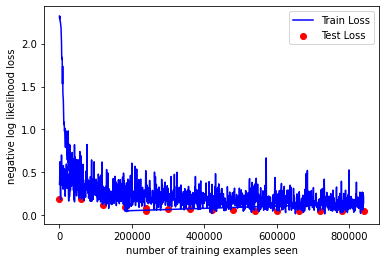

In [38]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()